# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import Transfer


# Loading datasets

In [2]:
# French data
train = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test1.csv')
test2 = pd.read_csv('data/test2.csv')
test3 = pd.read_csv('data/test3.csv')

# Italian data
train_it = pd.read_csv('data/train_it.csv')
test1_it = pd.read_csv('data/test1_it.csv')
test2_it = pd.read_csv('data/test2_it.csv')


# Loading experts

### Forecasts

In [3]:
# French data
gamtrain = pd.read_csv('data/experts/gamtrain_forecast.csv')['x']
gam1 = pd.read_csv('data/experts/gam1_forecast.csv')['x']
gam2 = pd.read_csv('data/experts/gam2_forecast.csv')['x']
gbm1 = pd.read_csv('data/experts/gbm1_forecast.csv')['x']
gbm2 = pd.read_csv('data/experts/gbm2_forecast.csv')['x']

# Italian data
gamittrain = pd.read_csv('data/experts/gamit_forecast.csv')['x']
gam1_it = pd.read_csv('data/experts/gam1it_forecast.csv')['x']
gam2_it = pd.read_csv('data/experts/gam2it_forecast.csv')['x']
gbm1_it = pd.read_csv('data/experts/gbm1it_forecast.csv')['x']
gbm2_it = pd.read_csv('data/experts/gbm2it_forecast.csv')['x']


### Spline

In [4]:
# French data
basis = pd.read_csv('data/experts/basis_france.csv')
basis1 = pd.read_csv('data/experts/basis1_france.csv')
basis2 = pd.read_csv('data/experts/basis2_france.csv')
betas = pd.read_csv('data/experts/betas_france.csv')

# Italian data
basis_it = pd.read_csv('data/experts/basis_it.csv')
basis1_it = pd.read_csv('data/experts/basis1_it.csv')
basis2_it = pd.read_csv('data/experts/basis2_it.csv')
betas_it = pd.read_csv('data/experts/betas_it.csv')


# Transfer learning

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch


class Transfer():
    def __init__(self, betas, betas_it, basis, basis_it, y, y_it, K=75):
        # Coefficients learned on the French source data
        self.betas = betas.copy()
        self.betas_vec = betas['betas_france'].to_numpy()
        # Coefficients learned on the Italian source data
        self.betas_it = betas_it.copy()
        self.betas_it_vec = betas_it['betas_italy'].to_numpy()
        # Spline basis for the French source data
        self.basis = basis.to_numpy()[:, 1:]
        # Spline basis for the Italian source data
        self.basis_it = basis_it.to_numpy()[:, 1:]
        # Number of iterations
        self.K = K
        #  Target data (French)
        self.y = y
        #  Target data (Italian)
        self.y_it = y_it
        #  Scale parameter (should be around 4)
        self.rho = y.sum() / y_it.sum()

    def compute_alpha(self, t, country='fr'):
        if country == 'fr':
            basis = self.basis
        else:
            basis = self.basis_it
        lam_max = np.real(np.linalg.eig(basis[:t].T@basis[:t])[0]).max()
        lam_min = np.real(np.linalg.eig(basis[:t].T@basis[:t])[0]).min()
        return .4/(lam_max + lam_min + 1e-8)

    def grad_loss(self, t, country='fr'):
        self.alpha = self.compute_alpha(t, country)
        if country == 'fr':
            y = self.y
            beta = self.betas_vec
            basis = self.basis
        else:
            y = self.y_it
            beta = self.betas_it_vec
            basis = self.basis_it
        beta_te = torch.tensor(beta, requires_grad=True)
        y_te = torch.tensor(y[:-t])
        basis_te = torch.tensor(basis[:-t].T)
        # Compute the loss
        loss = torch.sum((y_te - beta_te@basis_te)**2)
        # Compute the gradient
        loss.backward()
        # Return the gradient to numpy
        return self.alpha*beta_te.grad.numpy()

    def gam_ft(self):
        beta_t = self.betas_vec
        for k in range(self.K):
            beta_t = beta_t - self.grad_loss(k)
        return beta_t@self.basis.T

    # def gam_ft(self, type='test1'):
    #     if type == 'test1':
    #         l = len(test1)
    #     elif type == 'test2':
    #         l = len(test2)
    #     tuning = []
    #     for t in tqdm(range(l)):
    #         tuning.append(self.gam_ft_t(t))
    #     return tuning

    def gam_delta(self):
        # NOT WORKING
        beta_t_it = self.betas_it_vec
        for t in range(self.K):
            beta_t_it = beta_t_it - self.grad_loss(t, country='it')
        delta_t = beta_t_it - self.betas_it_vec
        beta_t = self.betas_vec + self.rho*delta_t
        return beta_t.T@self.basis


In [6]:
tr_tr = Transfer(betas, betas_it, basis, basis_it, gamtrain, gamittrain, K=75)
ft_tr = tr_tr.gam_ft()

In [7]:
tr_te1 = Transfer(betas, betas_it, basis1, basis1_it, gam1, gam1_it, K=75)
ft_te1 = tr_te1.gam_ft()

In [8]:
tr_te2 = Transfer(betas, betas_it, basis2, basis2_it, gam2, gam2_it, K=75)
ft_te2 = tr_te2.gam_ft()

# Plotting the results

In [23]:
def display_plots(type='train', method='ft'):
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    plt.figure(figsize=(16, 8))
    plt.xlabel = 'Time'
    if type == 'train':
        if method == 'ft':
            plt.title = 'FineTuning on Train data'
            plt.plot(gamtrain, '--', label='GAM' + ', MAPE: ' + str(round(mape(train['Consommation'], gamtrain), 2)), alpha=.7)
            plt.plot(ft_tr, '--', label='GAM FT' + ', MAPE: ' + str(round(mape(train['Consommation'], ft_tr), 2)), alpha=.7)
            plt.plot(train['Consommation'], label='Observed', color='black', alpha=.3)
        elif method == 'delta':
            plt.plot(gamtrain, '--', label= 'GAM' + ', MAPE: ' + str(round(mape(train['Consommation'], gamtrain), 2)), alpha=.7)
            plt.plot(ft_delta, '--', label='GAM Delta' + ', MAPE: ' + str(round(mape(train['Consommation'], ft_delta), 2)), alpha=.7)
            plt.plot(train['Consommation'], label='Observed', color='black', alpha=.3)
    elif type == 'test1':
        if method == 'ft':
            plt.title = 'FineTuning on Test1 data'
            plt.plot(gam1, '--', label='GAM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gam1), 2)), alpha=.7)
            plt.plot(ft_te1, '--', label='GAM FT' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_te1), 2)), alpha=.7)
            plt.plot(test1['Consommation'], label='Observed', color='black', alpha=.3)
        elif method == 'delta':
            plt.plot(gam1, '--', label='GAM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gam1), 2)), alpha=.7)
            plt.plot(ft_delta1, '--', label='GAM Delta' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_delta1), 2)), alpha=.7)
            plt.plot(test1['Consommation'], label='Observed', color='black', alpha=.3)
    elif type == 'test2':
        if method == 'ft':
            plt.title = 'FineTuning on Test2 data'
            plt.plot(gam2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gam2), 2)), alpha=.7)
            plt.plot(ft_te2, '--', label='GAM FT' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_te2), 2)), alpha=.7)
            plt.plot(test2['Consommation'], label='Observed', color='black', alpha=.3)
        elif method == 'delta':
            plt.plot(gam2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gam2), 2)), alpha=.7)
            plt.plot(ft_delta2, '--', label='GAM Delta' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_delta2), 2)), alpha=.7)
            plt.plot(test2['Consommation'], label='Observed', color='black', alpha=.3)
    plt.legend()
    plt.show()

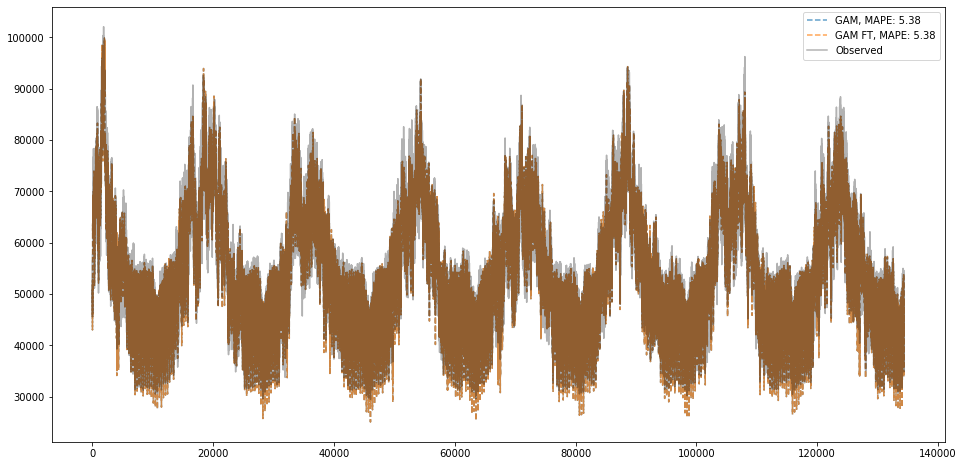

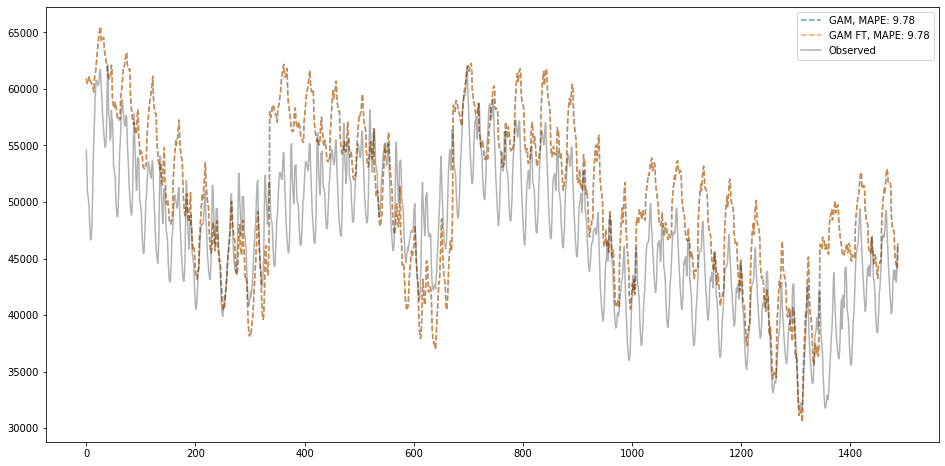

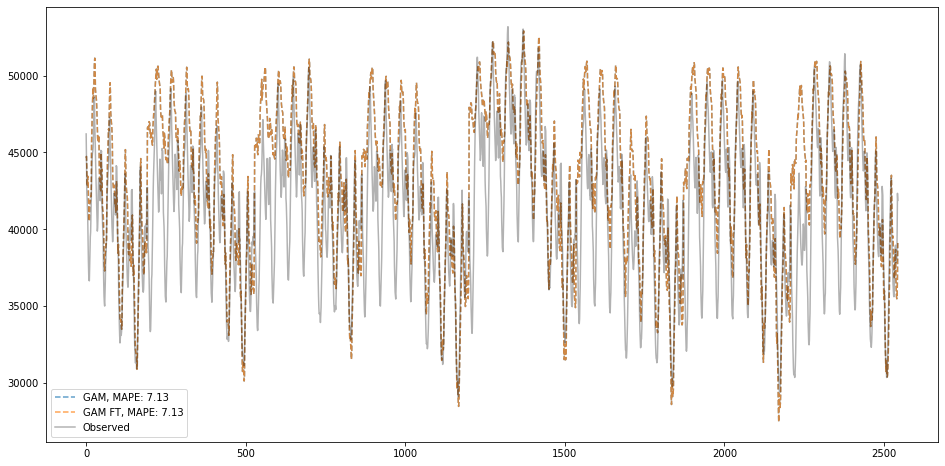

In [24]:
display_plots(type='train', method='ft')
display_plots(type='test1', method='ft')
display_plots(type='test2', method='ft')